# Team Members

Dhagash Desai, Lina Hashem

# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchvision import datasets, transforms
import random as rand
%matplotlib inline

# Dataloader

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])



trainset = datasets.SVHN('data', split="train", download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

testset = datasets.SVHN('data', split="test", download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=6128, shuffle=True)

Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat


In [3]:
image, label = next(iter(trainloader))
print(len(trainset))
print(len(testset))

73257
26032


In [4]:
image.shape
(image.view(image.shape[0],-1)).shape


torch.Size([128, 3072])

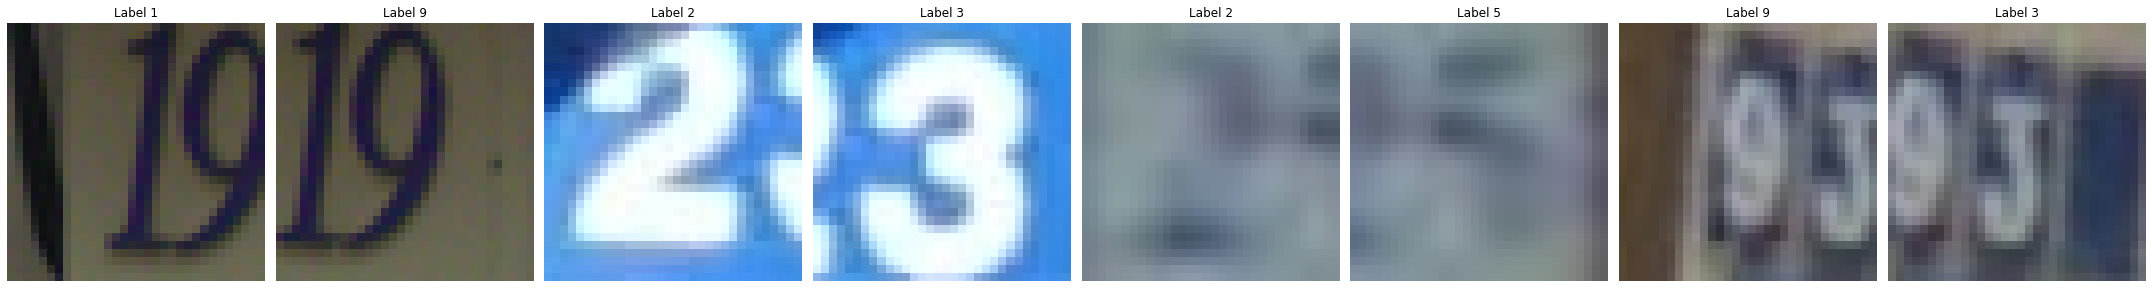

In [5]:
fig, ax = plt.subplots(1, 8)
fig.set_size_inches(30, 4)
for i in range(8):
    img, lbl = trainset[i]
    img_disp = img.permute(1,2,0)
    ax[i].imshow(img_disp)
    ax[i].axis("off")
    ax[i].set_title(f"Label {lbl}")

plt.tight_layout()
plt.show()

# Model

In [6]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(3072, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x


# Training

In [7]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 50
steps = 0


train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/50..  Training Loss: 2.140..  Test Loss: 2.011..  Test Accuracy: 0.281
Epoch: 2/50..  Training Loss: 1.807..  Test Loss: 1.801..  Test Accuracy: 0.376
Epoch: 3/50..  Training Loss: 1.567..  Test Loss: 1.615..  Test Accuracy: 0.453
Epoch: 4/50..  Training Loss: 1.440..  Test Loss: 1.485..  Test Accuracy: 0.508
Epoch: 5/50..  Training Loss: 1.355..  Test Loss: 1.403..  Test Accuracy: 0.540
Epoch: 6/50..  Training Loss: 1.267..  Test Loss: 1.347..  Test Accuracy: 0.567
Epoch: 7/50..  Training Loss: 1.214..  Test Loss: 1.288..  Test Accuracy: 0.592
Epoch: 8/50..  Training Loss: 1.177..  Test Loss: 1.275..  Test Accuracy: 0.598
Epoch: 9/50..  Training Loss: 1.155..  Test Loss: 1.230..  Test Accuracy: 0.613
Epoch: 10/50..  Training Loss: 1.132..  Test Loss: 1.216..  Test Accuracy: 0.617
Epoch: 11/50..  Training Loss: 1.126..  Test Loss: 1.223..  Test Accuracy: 0.619
Epoch: 12/50..  Training Loss: 1.119..  Test Loss: 1.226..  Test Accuracy: 0.612
Epoch: 13/50..  Training Loss: 1.107.

In [8]:

def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 32, 32).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "SVNH":
        ax2.set_yticklabels(np.arange(10))

    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

plt.tight_layout()

<Figure size 432x288 with 0 Axes>

# Testing

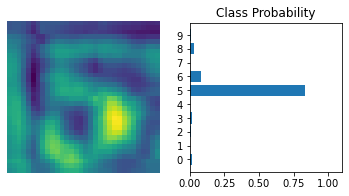

In [9]:
# Import helper module (should be in the repo)


# Test out your network!

model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D vector
img = img.view(1, 3072)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)
ps = torch.exp(output)
view_classify(img.view(3, 32, 32), ps, version='SVNH')
